In [2]:
from igraph import Graph
import numpy as np
import pandas as pd
import igraph
import networkx as nx
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import statistics

In [3]:
nodes=pd.read_csv('Nodes_definitivo.csv')
edges=pd.read_csv('Edges_df6.csv')

#### Individuiamo il Giant Component

In [4]:
g_nx=nx.from_pandas_edgelist(edges,source='Source',target='Target')
component_subgraph_list = list(nx.connected_components(g_nx))
largest_component = list(max(component_subgraph_list,key=len))


In [5]:
nodes_list=list(nodes.Id)
new_edges=edges[(edges['Source'].isin(largest_component)) & (edges['Target'].isin(largest_component))]
new_g=Graph.DataFrame(edges=new_edges[['Source','Target']],directed=True)

In [8]:
#codice per identificare giant component
nodes['Giant_Component']=0

colour=[]
for index in largest_component:
    subset=nodes[nodes.Id==index]
    if subset.empty == False:
        sub_index=subset.index
        nodes.at[sub_index,'Giant_Component']=1
    else:
        continue

#### Applichiamo leading eigenvector

In [143]:
eigen=new_g.community_leading_eigenvector(2)
eigen.summary()

'Clustering with 5190 elements and 2 clusters'

In [144]:
eigen_nodes=eigen.graph.vs["name"]
df_eigen=pd.DataFrame({'nodes':eigen_nodes,'clusters':eigen._membership})

<AxesSubplot:>

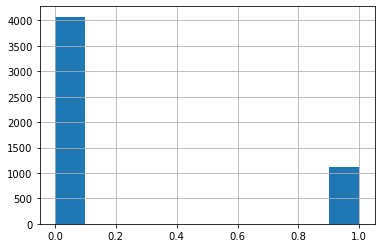

In [145]:
df_eigen["clusters"].hist()

In [146]:
df_eigen.groupby("clusters")["clusters"].count()

clusters
0    4073
1    1117
Name: clusters, dtype: int64

In [147]:
def color_clusters(cluster_df,cluster_field,new_cluster_field_name):
    clusters=list(set(cluster_df[cluster_field]))
    nodes[new_cluster_field_name]=0

    for index, row in cluster_df.iterrows():
        subset=nodes[nodes.Id==int(row['nodes'])]
        if subset.empty == False:
            sub_index=subset.index
            for cluster in clusters:
                if row['clusters']==cluster:
                    nodes.at[sub_index,new_cluster_field_name]=cluster+1
        else:
            continue

In [148]:
color_clusters(df_eigen,'clusters','cluster_eigen')

In [8]:
#clusters=list(set(df_eigen.clusters))
#nodes['Cluster_eigen']=0
#
#colour=[]
#for index, row in df_eigen.iterrows():
#    subset=nodes[nodes.Id==int(row['nodes'])]
#    if subset.empty == False:
#        sub_index=subset.index
#        for cluster in clusters:
#            if row['clusters']==cluster:
#                nodes.at[sub_index,'Cluster_eigen']=cluster+1
#    else:
#        continue

In [3]:
#utile solo nel caso che il dataframe di partenza presenti gli hex colors invece dei cluster

#for i,r in dummy.iterrows():
#    if r['Colour']=='#aaaacc':
#        dummy.at[i,'Colour']=0
#    if r['Colour']=='#007474':
#        dummy.at[i,'Colour']=1
#    if r['Colour']=='#fb1239':
#        dummy.at[i,'Colour']=2

#### Creazione indice e applicazione k-means

In [149]:
contiguous_nodes_dict={}

for node in nodes.Id:
    lista_target=list(new_edges[new_edges.Source==node]['Target'])
    lista_source=list(new_edges[new_edges.Target==node]['Source'])
    lista_tot=lista_target+lista_source
    if lista_tot != []:
        contiguous_nodes_dict[node]=lista_tot

In [150]:
def Jaccard(nodesA,nodesB):
    intersect = [value for value in nodesA if value in nodesB]
    union=list(set(nodesA+nodesB))
    compute_jaccard=len(intersect)/len(union)
    return compute_jaccard

In [29]:
adj=nx.adjacency_matrix(G_directed)
from sklearn.cluster import KMeans
kmeans2 = KMeans(n_clusters=2, random_state=0,n_init=100,max_iter=1000).fit(adj)

In [30]:
kmeans2=pd.DataFrame({"gruppo":kmeans2.labels_})

In [31]:
kmeans2.groupby("gruppo")["gruppo"].count()

gruppo
0    4110
1    1080
Name: gruppo, dtype: int64

In [151]:
distance_matrix_j=[[ Jaccard(values_col,values_row) for values_row in contiguous_nodes_dict.values()] for values_col in contiguous_nodes_dict.values()]

In [152]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0,n_init=100,max_iter=1000,algorithm="elkan").fit(distance_matrix_j)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

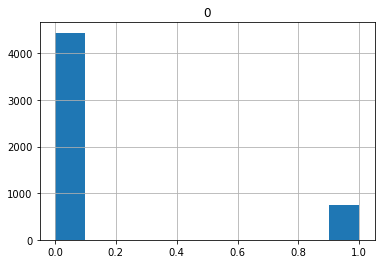

In [153]:
pd.DataFrame(kmeans.labels_).hist()

In [154]:
df_means=pd.DataFrame({'nodes':contiguous_nodes_dict.keys(),'clusters':kmeans.labels_})

In [155]:
color_clusters(df_means,'clusters','cluster_kmeans')

#### Girvan-Newman

In [160]:
new_G = nx.from_edgelist([(names[x[0]], names[x[1]])
                      for names in [new_g.vs['name']] # simply a let
                      for x in new_g.get_edgelist()], nx.DiGraph())

In [161]:
new_G=new_G.to_undirected()

In [162]:
def edge_to_remove(graph):
  G_dict = nx.edge_betweenness_centrality(graph)
  edge = ()

  # extract the edge with highest edge betweenness centrality score
  for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
      edge = key
      break

  return edge

In [163]:
def girvan_newman(graph):
	# find number of connected components
	sg = nx.connected_components(graph)
	sg_count = nx.number_connected_components(graph)

	while(sg_count == 1):
		graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
		sg = nx.connected_components(graph)
		sg_count = nx.number_connected_components(graph)

	return sg

In [164]:
# find communities in the graph
c = girvan_newman(new_G.copy())

# find the nodes forming the communities
node_groups = []

for i in c:
  node_groups.append(list(i))

In [8]:
nodes['Colour_GN']=0

for group in range(0,len(node_groups)):
    for idx in node_groups[group]:
        subset=nodes[nodes.Id==int(idx)]
        if subset.empty == False:
            sub_index=subset.index
            nodes.at[sub_index,'Colour_GN']=group+1
        else:
            continue

NameError: name 'node_groups' is not defined

#### Valutazione Grafo

In [6]:
G_directed=nx.from_pandas_edgelist(new_edges,source='Source',target='Target',create_using=nx.DiGraph())

In [7]:
#creazione grafo in networkx della Giant Component
G_nx=nx.from_pandas_edgelist(new_edges,source='Source',target='Target')

In [9]:
#numerosità del grafo completo e giant component
nodes.groupby("hashtags")["gruppo"].count()
nodes[nodes["Giant_Component"]==1].groupby("hashtags")["gruppo"].count()

hashtags
#NoGreenPass        1545
#vaccinatevi        1205
@CasaPoundItalia     297
@EnricoLetta         975
@matteosalvinimi    1168
Name: gruppo, dtype: int64

Assortativity

In [9]:
#Assortativity per intero grafo
#nx.degree_assortativity_coefficient(g_nx)
Assortativity=nx.degree_pearson_correlation_coefficient(g_nx) #più veloce
Assortativity

-0.2152581913514963

In [10]:
#Assortativity per la sola giant component
nx.degree_pearson_correlation_coefficient(G_directed)

-0.20792062392886407

La nostra rete è quindi disassortativa:
- Hubs tend to connect to small nodes.
- Disassortative networks have difficulty forming a giant
component (ops? ahahah)
- Hub removal is more damaging in disassortative networks, as in these the
hubs connect to many small-degree nodes, which fall off the network
once a hub is deleted.

Altri indici

In [37]:
#nx.degree_mixing_dict(g_nx) #cos'è??

In [17]:
#Structural cohesion:
# Connectivity measures the minimum number of elements (vertices or edges) that must be removed to 
# disconnect the graph
# edge connectivity
print(nx.edge_connectivity(G_nx))
#print(nx.edge_connectivity(G_directed))

KeyboardInterrupt: 

In [ ]:
#node connectivity
print(nx.node_connectivity(G_nx))
#print(nx.node_connectivity(G_directed))

1
0


In [ ]:
#density
#The density of a graph is a measure of how many ties between actors exist compared to how many 
#ties between actors are possible. A dense graph is a graph in which the number of edges is close 
#to the maximal number of edges. 
#NB: The density is 0 for a graph without edges and 1 for a complete graph

#print(nx.density(G_nx))
print(nx.density(G_directed))
#il nostro grafo è sparso

0.0005404199115440214
0.000270692672471892


In [14]:
#print(nx.eccentricity(g_nx)) grafo non connesso, non si può calcolare l'eccentricity
# It is defined as the maximum distance of one vertex from other vertex. The maximum distance 
# between a vertex to all other vertices is considered as the eccentricity of the vertex.
eccentricity=nx.eccentricity(G_nx)

In [15]:
#The radius of G is the value of the smallest eccentricity.
nx.radius(G_nx)
#min(eccentricity.values())

7

In [16]:
#The diameter of G is the value of the greatest eccentricity.
nx.diameter(G_nx)
#max(eccentricity.values())

14

In [120]:
#reciprocity is a measure of the likelihood of vertices in a directed network to be mutually 
# linked
overall_reciprocity=nx.overall_reciprocity(G_directed)
overall_reciprocity

# 0 -> non ci sono scambi di retweet?

0.0035665294924554186

Degree Analysis (HUBS & Spamm Users)

In [ ]:
#DEGREE
#Degree is a simple centrality measure that counts how many neighbors a node has. 
# If the network is directed, we have two versions of the measure: 
# in-degree is the number of in-coming links, or the number of predecessor nodes; 
# out-degree is the number of out-going links, or the number of successor nodes.

In [8]:
out_degrees=dict(G_directed.out_degree())
out_degrees_sort=dict(sorted(out_degrees.items(), key=lambda item: item[1], reverse= True))
twitters=pd.DataFrame(list(out_degrees_sort.items()),columns=("id_utente","rt_fatti"))
twitters=pd.merge(twitters,nodes[["Id","Label","hashtags","Giant_Component"]],left_on="id_utente",right_on="Id",how="left")
twitters.drop("Id",axis=1,inplace=True)
twitters.head(20)
#possiamo notare che gli utenti più attivi siano quasi tutti appartenenti all'hashtag @matteosalvinimi

,id_utente,rt_fatti,Label,hashtags,Giant_Component
0,366660837,38,_fiorucci,@matteosalvinimi,1
1,810235254870937600,32,ferillo2,@matteosalvinimi,1
2,1174780873075544069,26,rosaroccaforte,@matteosalvinimi,1
3,1042691054,26,MastroRadu,@matteosalvinimi,1
4,2535751839,24,MarySpes,@matteosalvinimi,1
5,358626243,24,robymark1,@matteosalvinimi,1
6,1382258084567998469,20,Olindo35055898,@CasaPoundItalia,1
7,354778269,19,katakhon,@matteosalvinimi,1
8,1310209976,17,Ecatetriformis,@EnricoLetta,1
9,1409830264977645570,14,Luckyma89652325,@matteosalvinimi,1


In [20]:
#media dell'out degree
statistics.median(in_degrees.values())

0.0

In [44]:
twitters[twitters["rt_fatti"]<=5].count()/len(twitters)

id_utente          0.978035
rt_fatti           0.978035
Label              0.978035
hashtags           0.978035
Giant_Component    0.978035
dtype: float64

In [22]:
#percentuale di appartenenza degli utenti che hanno effettuato ritweet <=5
twitters[twitters["rt_fatti"]<=5].groupby("hashtags")["rt_fatti"].count()/twitters[twitters["rt_fatti"]<=5]["rt_fatti"].count()

hashtags
#NoGreenPass        0.303191
#vaccinatevi        0.237392
@CasaPoundItalia    0.057920
@EnricoLetta        0.187746
@matteosalvinimi    0.213751
Name: rt_fatti, dtype: float64

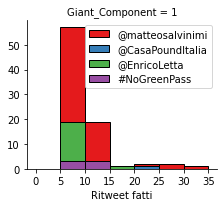

In [20]:
bins=np.arange(0, 40, 5)
g = sns.FacetGrid(twitters[twitters["rt_fatti"]>5], col="Giant_Component", hue="hashtags", palette="Set1", col_wrap=2)
g.map(plt.hist, 'rt_fatti', bins=bins, ec="k")
plt.xlabel("Ritweet fatti")
g.axes[-1].legend()
plt.xticks(np.arange(0, 40, 5))

plt.show()

In [55]:
#percentuale di appartenenza dei top30 utenti più attivi
twitters.head(30).groupby("hashtags")["rt_fatti"].count()/twitters.head(30)["rt_fatti"].count()

hashtags
#NoGreenPass        0.100000
@CasaPoundItalia    0.033333
@EnricoLetta        0.066667
@matteosalvinimi    0.800000
Name: rt_fatti, dtype: float64

In [67]:
#df dei gradi entranti di ciascun nodo
df_gradi_in=pd.DataFrame(in_degrees.items(),columns=["nodi","grado"])

In [68]:
#distribuzione dei nodi per i 5 gradi più ricorrenti
df_gradi_in.groupby("grado").count().head()

,nodi
grado,
0,4468
1,299
2,127
3,66
4,29


In [69]:
#percentuale di nodi con grado=0 (nessun retweet ricevuto)
round(df_gradi_in[df_gradi_in["grado"]==0]["grado"].count()/df_gradi_in["grado"].count(),4)

0.8609

In [42]:
#df dei gradi entranti di ciascun nodo
df_gradi_out=pd.DataFrame(out_degrees.items(),columns=["nodi","grado"])
round(df_gradi_out[df_gradi_out["grado"]==0]["grado"].count()/df_gradi_out["grado"].count(),4)

0.0925

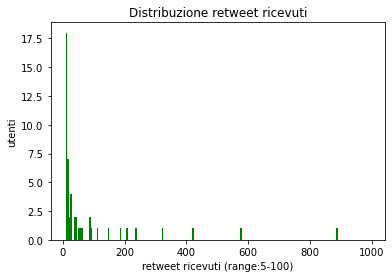

In [ ]:
import matplotlib.pyplot as plt
#distribuzione numero del numero dei retweet ricevuti in un range tra 5 e 100
def plot_in_degree_dist(G):
    bins=np.arange(10,1000,5)  
    degrees = sorted([G.in_degree(n) for n in G.nodes()])
    plt.hist(degrees, bins, color='green')
    plt.ylabel('utenti')
    plt.xlabel('retweet ricevuti (range:5-100)')
    plt.title('Distribuzione retweet ricevuti')
    plt.show()

plot_in_degree_dist(G_directed)

# da questo plot possiamo farci un idea della distribuzione degli hub 
# (nodi con un numero di archi entranti anomalo rispetto al resto della rete )

In [9]:
in_degrees=dict(G_directed.in_degree())
in_degrees_sort=dict(sorted(in_degrees.items(), key=lambda item: item[1], reverse= True))
HUBS=pd.DataFrame(list(in_degrees_sort.items()),columns=("id_utente","rt_ricevuti"))
HUBS=pd.merge(HUBS,nodes[["Id","Label","hashtags"]],left_on="id_utente",right_on="Id",how="left")
HUBS.drop("Id",axis=1,inplace=True)
HUBS.head(5)

,id_utente,rt_ricevuti,Label,hashtags
0,1364298062919794688,1080,Lorenzo62752880,#NoGreenPass
1,22038676,579,mariannaaprile,#vaccinatevi
2,231902290,415,Cartabellotta,#vaccinatevi
3,270839361,332,matteosalvinimi,@matteosalvinimi
4,215699843,245,CasaPoundItalia,@CasaPoundItalia


In [126]:
print(min(in_degrees_sort.values()))
print(max(in_degrees_sort.values()))

0
1080


Centrality

In [127]:
#The in-degree centrality for a node v is the fraction of nodes its incoming edges are connected to
#top10 dei nodi con il maggior numero di archi entranti (i più retwettati)--> HUBS
in_degree_centrality=nx.in_degree_centrality(G_directed)
in_degree_centrality_sort=dict(sorted(in_degree_centrality.items(), key=lambda item: item[1], reverse= True))
top10_IN_C=list(in_degree_centrality_sort.items())[:10]
top10_IN_C

[(1364298062919794688, 0.20813258816727692),
 (22038676, 0.11158219310079012),
 (231902290, 0.0799768741568703),
 (270839361, 0.06398149932549624),
 (215699843, 0.047215263056465596),
 (1238800491632607232, 0.039892079398728075),
 (4882542093, 0.028521873193293502),
 (1302616789348691968, 0.027943727115051067),
 (419622371, 0.027558296396222776),
 (1434532915417919488, 0.021005974176141837)]

In [128]:
#The out-degree centrality for a node v is the fraction of nodes its outcoming edges are connected to
#top10 dei nodi con il maggior numero di archi uscenti (chi ha retwittato di più)
out_degree_centrality=nx.out_degree_centrality(G_directed)
out_degree_centrality_sort=dict(sorted(out_degree_centrality.items(), key=lambda item: item[1], reverse= True))
top10_OUT_C=list(out_degree_centrality_sort.items())[:10]
top10_OUT_C

[(366660837, 0.007323183657737521),
 (810235254870937600, 0.0061668915012526495),
 (1174780873075544069, 0.005010599344767778),
 (1042691054, 0.005010599344767778),
 (2535751839, 0.004625168625939487),
 (358626243, 0.004625168625939487),
 (1382258084567998469, 0.003854307188282906),
 (354778269, 0.0036615918288687606),
 (1310209976, 0.00327616111004047),
 (1409830264977645570, 0.002698015031798034)]

In [131]:
#CLOSENESS CENTRALITY
# of a node is a measure of centrality in a network, 
# calculated as the reciprocal of the sum of the length of the shortest paths between the node 
# and all other nodes in the graph. Thus, the more central a node is, the closer it is to all 
# other nodes.
closeness_centrality=nx.closeness_centrality(G_directed)

In [132]:
#trovo i top5 utenti per closeness_centrality
closeness_centrality_sort=dict(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse= True))
top10_CC=pd.DataFrame(list(closeness_centrality_sort.items())[:5],columns=("id_utente","closeness centrality"))
top10_CC=pd.merge(top10_CC,nodes[["Id","Label"]],left_on="id_utente",right_on="Id",how="left")
top10_CC.drop("Id",axis=1,inplace=True)
top10_CC

,id_utente,closeness centrality,Label
0,1364298062919794688,0.199657,Lorenzo62752880
1,22038676,0.135710,mariannaaprile
2,231902290,0.080743,Cartabellotta
3,4882542093,0.057145,lordfed3
4,215699843,0.049076,CasaPoundItalia


In [129]:
#BETWEENNESS CENTRALITY
#betweenness centrality is a measure of centrality in a graph based on shortest paths. 
#Centrality misura l’importanza di un nodo nelle «comunicazioni» con gli altri nodi e
#quindi l’ influenza all'interno di una rete in virtù del «controllo sulle informazioni» che passano,
#pertanto si riferisce a quanto un nodo sia di passaggio 
betweenness_centrality=nx.betweenness_centrality(G_nx)

In [130]:
#trovo i top5 utenti per betweenness_centrality
betweenness_centrality_sort=dict(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse= True))
top5_BC=pd.DataFrame(list(betweenness_centrality_sort.items())[:5],columns=("id_utente","betweenness centrality"))
top5_BC=pd.merge(top5_BC,nodes[["Id","Label"]],left_on="id_utente",right_on="Id",how="left")
top5_BC.drop("Id",axis=1,inplace=True)
top5_BC

,id_utente,betweenness centrality,Label
0,1364298062919794688,0.468372,Lorenzo62752880
1,22038676,0.376630,mariannaaprile
2,231902290,0.171784,Cartabellotta
3,270839361,0.137820,matteosalvinimi
4,419622371,0.087509,EnricoLetta


##### Percolation?

In [47]:
from percolation import *

ModuleNotFoundError: No module named 'percolation'

In [ ]:
percolation_centrality